In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Load datasets
df = pd.read_csv("./../datasets/clean_walmart.csv", parse_dates=["Date"])

In [3]:
df["MA4"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(4).mean()

In [4]:
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

In [6]:
df = df.dropna()
print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
4      1     1 2010-03-05      21827.90        False        46.50       2.625   
5      1     1 2010-03-12      21043.39        False        57.79       2.667   
6      1     1 2010-03-19      22136.64        False        54.58       2.720   
7      1     1 2010-03-26      26229.21        False        51.45       2.732   
8      1     1 2010-04-02      57258.43        False        62.27       2.719   

   MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  IsHoliday_y  Type  \
4        0.0        0.0        0.0  ...         8.106        False     A   
5        0.0        0.0        0.0  ...         8.106        False     A   
6        0.0        0.0        0.0  ...         8.106        False     A   
7        0.0        0.0        0.0  ...         8.106        False     A   
8        0.0        0.0        0.0  ...         7.808        False     A   

     Size  Year Month  Week      Lag1      Lag4         

In [8]:
# Features and target
X = df[["Store","Dept","Lag1","Lag4","MA4","Temperature","Fuel_Price","CPI","Unemployment","Week","Month","Year"]]
y = df["Weekly_Sales"]

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost RMSE:", rmse)

XGBoost RMSE: 3093.578847440895


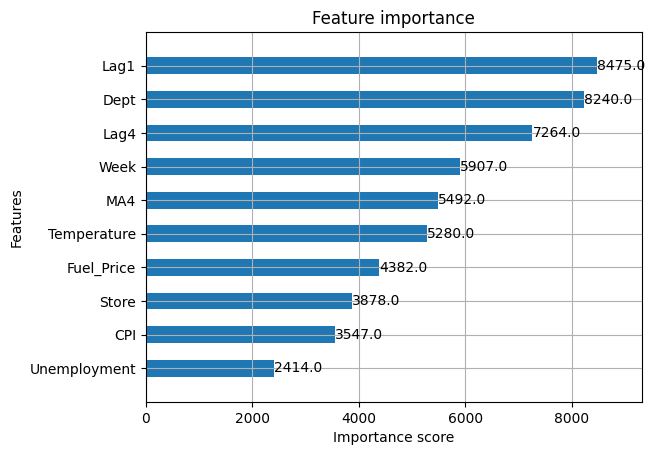

In [13]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.show()

In [12]:
# Select columns to export for Power BI
df.loc[X_test.index, "Forecast_XGBoost"] = model.predict(X_test)
export_df = df[["Date", "Store", "Dept", "Weekly_Sales", "Forecast_XGBoost"]]

# Save
export_df.to_csv("./../datasets/xgboost_forecasts.csv", index=False)
print("✅ XGBoost forecasts saved as xgboost_forecasts.csv")

✅ XGBoost forecasts saved as xgboost_forecasts.csv
